<a href="https://colab.research.google.com/github/priiyamjoshii/Music-generation-with-GAN/blob/main/Gan_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pretty midi since we are dealing with midi files

!pip install pretty_midi
!pip install tensorflow
!pip install matplotlib
!pip install music21 librosa pydub
!pip install pydub
!pip install midi2audio
!apt-get install -y fluidsynth
# Install timidity
!apt-get install -y timidity

In [ ]:
#conversion of xlsx to csv
from google.colab import files
import pandas as pd

# Read Excel file
excel_file_path = 'Mark Distribution.xlsx'
df = pd.read_excel(excel_file_path)

# Save as CSV
csv_file_path = 'Mark Distribution.csv'
df.to_csv(csv_file_path, index=False)
files.download('Mark Distribution.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#tokenization, conversion and padding of the input jazz midi files

import pandas as pd
from google.colab import files
from ast import literal_eval

# Load your CSV file
data = pd.read_csv('Bulk.csv')

# Tokenization and Integer Encoding
all_notes = set()
for column in ['Notes', 'Unique_notes']:
    all_notes.update(note for notes in data[column] for note in eval(notes) if isinstance(notes, str))

unique_notes = sorted(list(all_notes))
note_to_int = {note: i for i, note in enumerate(unique_notes)}

# Convert notes to integers
for column in ['Notes', 'Unique_notes']:
    data[column] = data[column].apply(lambda x: [note_to_int[note] for note in eval(x)] if isinstance(x, str) else [note_to_int[str(x)]])



# Save the preprocessed data to a new CSV file
data.to_csv('preprocessed_data_Bulk.csv', index=False)

#files.download('preprocessed_data_Bulk.csv')



In [ ]:
# IQR, BOX PLOTS AND CUMULATIVE DISTRIBUTION PLOTS AFTER CONVERSION INTO GAN FAVOURED INPUTS


import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from google.colab import files

# Ask for the Google Drive link
drive_link = input("Please provide the Google Drive link for the CSV file: ")

# Extract the file ID from the link
file_id = drive_link.split("/")[-2]

# Construct the download link
download_link = f"https://drive.google.com/uc?id={file_id}"

# Download the CSV file
response = requests.get(download_link)
data = pd.read_csv(StringIO(response.text))

# Display basic information
print("Number of Files:", data.shape[0])
print("\nFeatures in Each File:")
print(data.columns)

# Data Preprocessing
# Handle Missing Values
data = data.dropna()

# Analyze Dimensions and Feature Characteristics
print("\nData Dimensions:")
print(data.shape)
print("\nFeature Characteristics:")
print(data.describe())

# Interquartile Range (IQR) for Anomaly Detection
# Select only numeric columns for IQR calculation
numeric_data = data.select_dtypes(include='number')

# Check if there are numeric columns
if not numeric_data.empty:
    # Calculate IQR
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    IQR = Q3 - Q1

    # Set a multiplier for anomaly detection (you can adjust this based on your data)
    multiplier = 1.5

    # Identify and print anomalies for each feature
    print("\nAnomalies (IQR):")
    for column in numeric_data.columns:
        lower_bound = Q1[column] - multiplier * IQR[column]
        upper_bound = Q3[column] + multiplier * IQR[column]
        anomalies = numeric_data[(numeric_data[column] < lower_bound) | (numeric_data[column] > upper_bound)][column]
        if not anomalies.empty:
            anomaly_indices = anomalies.index
            print(f"Feature: {column}, Anomalies at Index: {list(anomaly_indices)}")
            print(f"Anomaly Range for {column}: ({lower_bound}, {upper_bound})")
            print(f"Q1 for {column}: {Q1[column]}")
            print(f"Q3 for {column}: {Q3[column]}")
        else:
            print(f"No anomalies found for {column}.")

    # Visualize IQR using box plots
    print("\nIQR Visualization:")
    plt.figure(figsize=(15, 8))
    sns.set(style="whitegrid")
    sns.boxplot(data=numeric_data, orient="v", palette="Set2")
    plt.title("Interquartile Range (IQR) Visualization")
    plt.xticks(rotation=45)
    plt.show()

    # Visualize Cumulative Distribution
    print("\nCumulative Distribution Plot:")
    plt.figure(figsize=(12, 6))
    sns.kdeplot(numeric_data['len_Uni_Notes'], cumulative=True)
    plt.title("Cumulative Distribution Plot for len_Uni_Notes")
    plt.xlabel("Length of Unique Notes")
    plt.ylabel("Cumulative Probability")
    plt.show()

    # Visualize Cumulative Distribution
    print("\nCumulative Distribution Plot:")
    plt.figure(figsize=(12, 6))
    sns.kdeplot(numeric_data['Len_Sequence'], cumulative=True)
    plt.title("Cumulative Distribution Plot for Len_Sequence")
    plt.xlabel("Length of Sequence Notes")
    plt.ylabel("Cumulative Probability")
    plt.show()

else:
    print("No numeric columns found for IQR calculation.")


In [ ]:
#APPROVED


import os
import librosa
import pandas as pd
import numpy as np
from pydub import AudioSegment
from music21 import converter, stream, note, tempo
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, BatchNormalization, LSTM, Input, Embedding, Dropout, Lambda, Attention
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K


# Load your preprocessed CSV file
data = pd.read_csv('preprocessed_data_Bulk.csv')

# Split the dataset into training and testing sets (70/30)
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Hyperparameters
latent_dim = 15
max_sequence_length = 60
batch_size = 10
epochs = 5
learning_rate = 0.001

# Discriminator
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model


    # Generator functions
def build_fully_connected_generator(latent_dim, output_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))
    return model


def build_lstm_generator(latent_dim, output_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(latent_dim, 1), activation='relu', return_sequences=True))  # return_sequences=True to stack LSTM layers
    model.add(BatchNormalization())
    model.add(LSTM(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))
    return model


def build_transformer_generator(latent_dim, output_shape):
    # Simplified transformer layer (adjust as needed)
    inputs = Input(shape=(latent_dim, 1))

    # Ensure that indices are within the valid range [0, latent_dim)
    indices = tf.clip_by_value(inputs, 0, latent_dim - 1)

    embedding = Embedding(input_dim=latent_dim, output_dim=512)(indices)  # Adjust output_dim
    attention = Attention()([embedding, embedding])
    dropout = Dropout(0.2)(attention)
    flattened = Flatten()(dropout)
    dense = Dense(512, activation='relu')(flattened)
    normalized = BatchNormalization()(dense)
    output = Dense(np.prod(output_shape), activation='tanh')(normalized)
    reshaped = Reshape(output_shape)(output)

    model = Model(inputs=inputs, outputs=reshaped)
    return model


def build_vae_generator(latent_dim, output_shape):
    # Encoder
    inputs = Input(shape=(latent_dim, 1))
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling layer with tf.function decorator
    @tf.function
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_hidden = Dense(512, activation='relu')
    decoder_out = Dense(np.prod(output_shape), activation='tanh')
    reshape = Reshape(target_shape=output_shape)

    decoder_hidden_out = decoder_hidden(z)
    decoded = reshape(decoder_out(decoder_hidden_out))

    model = Model(inputs=inputs, outputs=decoded)

    # VAE loss
    def vae_loss(inputs, outputs):
        xent_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    model.compile(optimizer='adam', loss=vae_loss)

    return model

# Build and compile the discriminator
discriminator = build_discriminator((max_sequence_length, 1))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Build GAN
gan_input = Input(shape=(latent_dim,))
generated_sequence = build_fully_connected_generator(latent_dim, (max_sequence_length, 1))(gan_input)
validity = discriminator(generated_sequence)

# The noise input for the GAN model
gan = Model(gan_input, validity)

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate))

# List to store generated music for evaluation
generated_samples_gan = []  # New list to store samples from all generators

# Training loop
for epoch in range(epochs):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim, 1))

    # Pad or truncate the sequence length for all generators
    for generator_function in [build_fully_connected_generator, build_lstm_generator, build_transformer_generator, build_vae_generator]:
        # Instantiate the generator model
        generator = generator_function(latent_dim, (max_sequence_length, 1))

        # Reshape noise for generator input
        noise_reshaped = noise.reshape((batch_size, latent_dim))

        if generator_function in [build_lstm_generator, build_vae_generator]:
            # LSTM and VAE require 3D input
            noise_reshaped = np.expand_dims(noise_reshaped, axis=-1)

        if noise_reshaped.shape[1] != latent_dim:
            if noise_reshaped.shape[1] < latent_dim:
                # Pad the sequence with zeros
                noise_reshaped = np.pad(noise_reshaped, ((0, 0), (0, latent_dim - noise_reshaped.shape[1])), 'constant')
            else:
                # Truncate the sequence
                noise_reshaped = noise_reshaped[:, :latent_dim]

        # Generate a batch of fake samples for each generator
        generated_data = generator.predict(noise_reshaped)

        # Train the discriminator for each generator
        fake_labels = np.zeros((batch_size, 1))
        d_loss = discriminator.train_on_batch(generated_data, fake_labels)

    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim, 1))

    # Reshape noise for generator input
    noise_reshaped = noise.reshape((batch_size, latent_dim))

    # LSTM and VAE require 3D input
    noise_reshaped = np.expand_dims(noise_reshaped, axis=-1)

    if noise_reshaped.shape[1] != latent_dim:
        if noise_reshaped.shape[1] < latent_dim:
            # Pad the sequence with zeros
            noise_reshaped = np.pad(noise_reshaped, ((0, 0), (0, latent_dim - noise_reshaped.shape[1])), 'constant')
        else:
            # Truncate the sequenceQ
            noise_reshaped = noise_reshaped[:, :latent_dim]

    # Create labels that represent "real" (1) samples to fool the discriminator
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise_reshaped, valid_labels)

    # Aggregate generated samples from all generators
    generated_samples_gan.extend(generated_data)

    # Print progress
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss}] [G loss: {g_loss}]")

# Flatten the generated samples list for evaluation
generated_samples_gan = np.array(generated_samples_gan).reshape(-1, max_sequence_length)

# Evaluate uniqueness of generated music
unique_gan = len(np.unique(generated_samples_gan, axis=0))

print(f"Unique samples - GAN Framework: {unique_gan}")

# Create a folder to store generated music samples
output_folder = 'generated_music_samples'
os.makedirs(output_folder, exist_ok=True)

# Save the last generated samples to the folder
for i, generated_sequence in enumerate(generated_samples_gan):
    midi_stream = stream.Stream()

    # Scale and shift the generated values to MIDI note range (0-127)
    scaled_values = (generated_sequence + 1) * 126  # Adjust this scaling based on your actual generated values range

    for note_value in scaled_values:
        new_note = note.Note(int(note_value))
        midi_stream.append(new_note)

    midi_stream.append(tempo.MetronomeMark(number=120))

    # Define the file path within the output folder
    file_path = os.path.join(output_folder, f'gm{i}.mid')

    # Write MIDI file to the specified path
    midi_stream.write('midi', fp=file_path)


# Define the new directory path
output_folder = 'generated_music_samples'

# Function to extract information from MIDI files
def extract_midi_info(file_path):
    midi_data = converter.parse(file_path)
    notes = [n.nameWithOctave for n in midi_data.flatten().notes]
    unique_notes = list(set(notes))
    len_sequence = len(notes)
    len_unique_notes = len(unique_notes)
    return {
        'Name': os.path.basename(file_path),
        'Notes': notes,
        'Len_Sequence': len_sequence,
        'Unique_notes': unique_notes,
        'len_Uni_Notes': len_unique_notes
    }

# Create a DataFrame to store the information
df_generated_info = pd.DataFrame(columns=['Name', 'Notes', 'Len_Sequence', 'Unique_notes', 'len_Uni_Notes'])

# Loop through generated music files
for i, generated_sequence in enumerate(generated_samples_gan):
    midi_file_path = os.path.join(output_folder, f'gm{i}.mid')
    midi_info = extract_midi_info(midi_file_path)
    df_generated_info = pd.concat([df_generated_info, pd.DataFrame([midi_info])])

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_folder, 'generated_music_info.csv')
df_generated_info.to_csv(csv_file_path, index=False)



#second value is the accuracy

1/1 [==============================] - 0s 87ms/step
Epoch 0/5 [D loss: [0.849158763885498, 0.5]] [G loss: 0.9836002588272095]
1/1 [==============================] - 0s 97ms/step
Epoch 1/5 [D loss: [0.8314979672431946, 0.699999988079071]] [G loss: 0.8633021116256714]
1/1 [==============================] - 0s 65ms/step
Epoch 2/5 [D loss: [0.7707176804542542, 0.6000000238418579]] [G loss: 0.916751503944397]
1/1 [==============================] - 0s 61ms/step
Epoch 3/5 [D loss: [0.7566496133804321, 0.6000000238418579]] [G loss: 1.1372687816619873]
1/1 [==============================] - 0s 64ms/step
Epoch 4/5 [D loss: [0.7948845028877258, 0.5]] [G loss: 1.0272467136383057]
Unique samples - GAN Framework: 50


In [ ]:
#rm *.mid

import shutil

# Specify the folder to be deleted
output_folder = 'generated_music_samples'

# Delete the folder and its contents if it exists
shutil.rmtree(output_folder, ignore_errors=True)

# Create a new empty folder
os.makedirs(output_folder, exist_ok=True)


In [ ]:
# for generated_music_csv

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from google.colab import files

# Ask for the Google Drive link
drive_link = input("Please provide the Google Drive link for the CSV file: ")

# Extract the file ID from the link
file_id = drive_link.split("/")[-2]

# Construct the download link
download_link = f"https://drive.google.com/uc?id={file_id}"

# Download the CSV file
response = requests.get(download_link)
data = pd.read_csv(StringIO(response.text))

# Display basic information
print("Number of Files:", data.shape[0])
print("\nFeatures in Each File:")
print(data.columns)

# Data Preprocessing
# Handle Missing Values
data = data.dropna()

# Analyze Dimensions and Feature Characteristics
print("\nData Dimensions:")
print(data.shape)
print("\nFeature Characteristics:")
print(data.describe())

# Interquartile Range (IQR) for Anomaly Detection
# Select only numeric columns for IQR calculation
numeric_data = data.select_dtypes(include='number')

# Check if there are numeric columns
if not numeric_data.empty:
    # Calculate IQR
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    IQR = Q3 - Q1

    # Set a multiplier for anomaly detection (you can adjust this based on your data)
    multiplier = 1.5

    # Identify and print anomalies for each feature
    print("\nAnomalies (IQR):")
    for column in numeric_data.columns:
        lower_bound = Q1[column] - multiplier * IQR[column]
        upper_bound = Q3[column] + multiplier * IQR[column]
        anomalies = numeric_data[(numeric_data[column] < lower_bound) | (numeric_data[column] > upper_bound)][column]
        if not anomalies.empty:
            anomaly_indices = anomalies.index
            print(f"Feature: {column}, Anomalies at Index: {list(anomaly_indices)}")
            print(f"Anomaly Range for {column}: ({lower_bound}, {upper_bound})")
            print(f"Q1 for {column}: {Q1[column]}")
            print(f"Q3 for {column}: {Q3[column]}")
        else:
            print(f"No anomalies found for {column}.")

    # Visualize IQR using box plots
    print("\nIQR Visualization:")
    plt.figure(figsize=(15, 8))
    sns.set(style="whitegrid")
    sns.boxplot(data=numeric_data, orient="v", palette="Set2")
    plt.title("Interquartile Range (IQR) Visualization")
    plt.xticks(rotation=45)
    plt.show()

    # Visualize Cumulative Distribution
    print("\nCumulative Distribution Plot:")
    plt.figure(figsize=(12, 6))
    sns.kdeplot(numeric_data['len_Uni_Notes'], cumulative=True)
    plt.title("Cumulative Distribution Plot for len_Uni_Notes")
    plt.xlabel("Length of Unique Notes")
    plt.ylabel("Cumulative Probability")
    plt.show()

    # Visualize Cumulative Distribution
    print("\nCumulative Distribution Plot:")
    plt.figure(figsize=(12, 6))
    sns.kdeplot(numeric_data['Len_Sequence'], cumulative=True)
    plt.title("Cumulative Distribution Plot for Len_Sequence")
    plt.xlabel("Length of Sequence Notes")
    plt.ylabel("Cumulative Probability")
    plt.show()

else:
    print("No numeric columns found for IQR calculation.")


In [ ]:
#too slow

!pip install mido pydub numpy

import os
import numpy as np
from mido import MidiFile
from pydub import AudioSegment

# Create the output folder if it doesn't exist
output_folder = 'generated_mp3'
os.makedirs(output_folder, exist_ok=True)

# Path to the folder containing MIDI files
midi_folder = 'generated_music_samples'

# Function to convert MIDI to MP3
def convert_midi_to_mp3(midi_path, mp3_path):
    midi = MidiFile(midi_path)

    # Create an empty audio segment
    audio = AudioSegment.silent(duration=0)

    for msg in midi.play():
        if msg.type == 'note_on':
            # Add a segment of silence for the note duration
            audio += AudioSegment.silent(duration=msg.time * 1000)

            # Generate a sine wave for the note with the specified frequency
            frequency = 440 * (2 ** ((msg.note - 69) / 12))  # Calculate frequency
            samples = (np.sin(2 * np.pi * np.arange(44100) * frequency / 44100)).astype(np.int16)

            # Convert the numpy array to an audio segment
            note_segment = AudioSegment(samples.tobytes(), frame_rate=44100, sample_width=2, channels=1)

            # Add the note segment to the overall audio
            audio += note_segment

    # Export the audio segment as an MP3 file
    audio.export(mp3_path, format='mp3')

# Iterate through all MIDI files in the input folder
for midi_file in os.listdir(midi_folder):
    if midi_file.endswith('.midi') or midi_file.endswith('.mid'):
        # Construct the full paths
        midi_path = os.path.join(midi_folder, midi_file)
        mp3_path = os.path.join(output_folder, os.path.splitext(midi_file)[0] + '.mp3')

        # Convert MIDI to MP3
        convert_midi_to_mp3(midi_path, mp3_path)

print("Conversion complete. MP3 files are in the 'generated_mp3' folder.")


In [ ]:
#timidity

# Install timidity
!apt-get install -y timidity

# Create the output folder if it doesn't exist
output_folder = 'generated_mp3'
os.makedirs(output_folder, exist_ok=True)

# Path to the folder containing MIDI files
midi_folder = 'generated_music_samples'

# Iterate through all MIDI files in the input folder
for midi_file in os.listdir(midi_folder):
    if midi_file.endswith('.midi') or midi_file.endswith('.mid'):
        # Construct the full paths
        midi_path = os.path.join(midi_folder, midi_file)
        mp3_path = os.path.join(output_folder, os.path.splitext(midi_file)[0] + '.mp3')

        # Use timidity to convert MIDI to WAV
        !timidity {midi_path} -Ow -o {mp3_path.replace('.mp3', '.wav')}

        # Use ffmpeg to convert WAV to MP3
        !ffmpeg -i {mp3_path.replace('.mp3', '.wav')} -acodec libmp3lame -ab 192k {mp3_path}

        # Remove the temporary WAV file
        !rm {mp3_path.replace('.mp3', '.wav')}

print("Conversion complete. MP3 files are in the 'generated_mp3' folder.")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
timidity is already the newest version (2.14.0-8ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Playing generated_music_samples/gm43.mid
MIDI file: generated_music_samples/gm43.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: 
Playing time: ~34 seconds
Notes cut: 0
Notes lost totally: 0
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfri

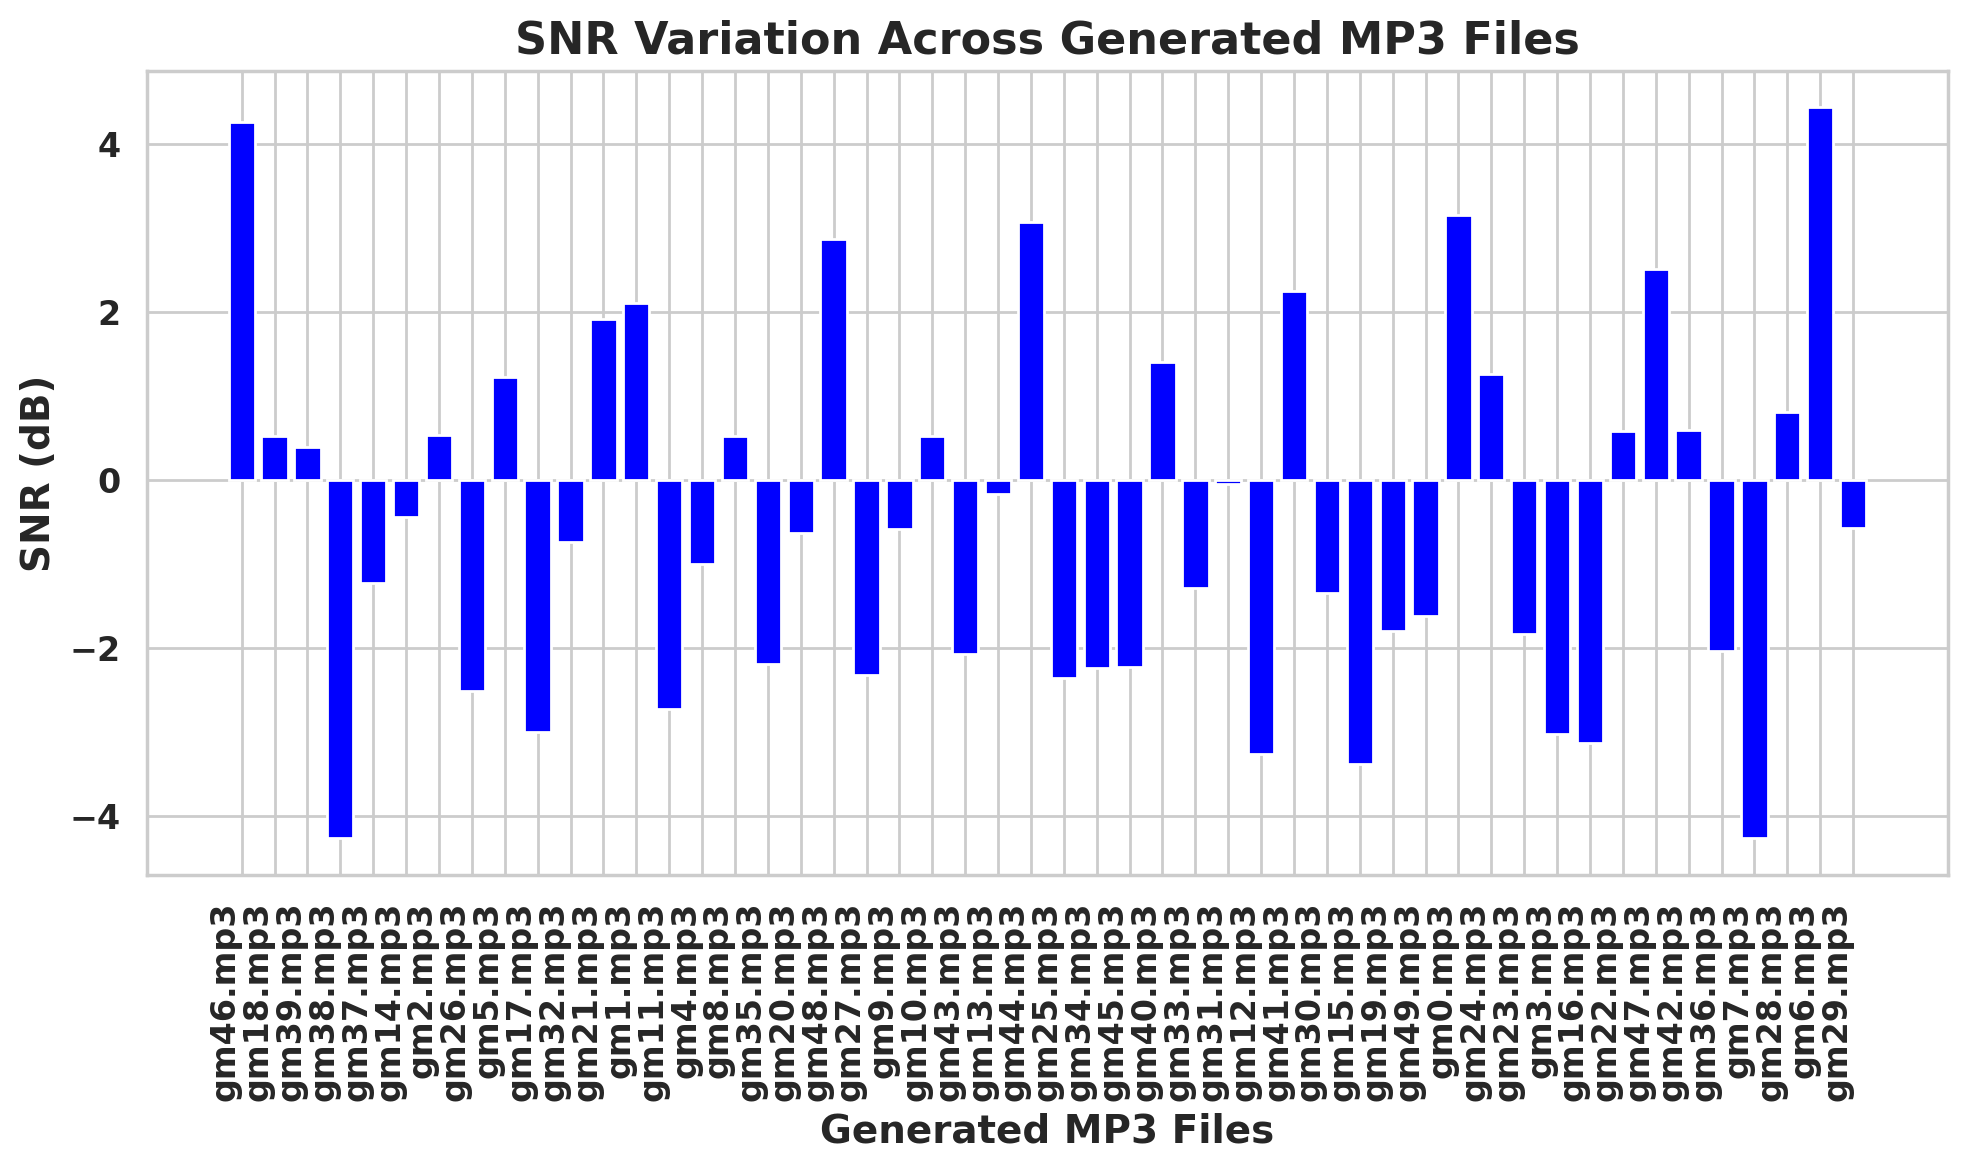

In [ ]:
import os
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt

# Define the directory path for generated MP3 files
output_folder_mp3 = 'generated_mp3'

# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(audio_path):
    audio = AudioSegment.from_mp3(audio_path)

    # Extract the signal and noise portions (assuming noise is at the beginning)
    signal_duration = 5 * 1000  # Use the first 5 seconds as the signal
    signal = np.array(audio[:signal_duration].get_array_of_samples())
    noise = np.array(audio[signal_duration:].get_array_of_samples())

    # Calculate SNR in dB
    snr = 10 * np.log10(np.mean(np.square(signal)) / np.mean(np.square(noise)))

    return snr

# Lists to store SNR values and file names
snr_values = []
file_names = []

# Loop through generated MP3 files
for mp3_file in os.listdir(output_folder_mp3):
    if mp3_file.endswith('.mp3'):
        mp3_file_path = os.path.join(output_folder_mp3, mp3_file)
        snr = calculate_snr(mp3_file_path)

        # Append SNR value and file name to lists
        snr_values.append(snr)
        file_names.append(mp3_file)

# Plot the SNR values
plt.figure(figsize=(10, 6))
plt.bar(file_names, snr_values, color='blue')
plt.xlabel('Generated MP3 Files', fontsize=14, fontweight='bold')
plt.ylabel('SNR (dB)', fontsize=14, fontweight='bold')
plt.title('SNR Variation Across Generated MP3 Files', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
#rm *.mid

import shutil

# Specify the folder to be deleted
output_folder = 'generated_mp3'

# Delete the folder and its contents if it exists
shutil.rmtree(output_folder, ignore_errors=True)

# Create a new empty folder
os.makedirs(output_folder, exist_ok=True)
